# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [18]:
pip install plotly

  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11435 sha256=0f2762a0c3f8fcc50cd0b6227856f7aedfeaaf42831103f434eb66310817c279
  Stored in directory: c:\users\bhara\appdata\local\pip\cache\wheels\f9\8d\8d\f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
Note: you may need to restart the kernel to use updated packages.


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

# from plotly import plotly
# import plotly.offline as offline
# import plotly.graph_objs as go
# offline.init_notebook_mode()
from collections import Counter

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [2]:
import pandas
data = pandas.read_csv('preprocessed_data.csv')
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [3]:
y = data.project_is_approved
X = data.drop(['project_is_approved'], axis=1)
X.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
pip install sklearn

In [4]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = 1/3, stratify=y)
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)

(72832, 8) (72832,)
(36416, 8) (36416,)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [26]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#BOW
vectorizer_bow = CountVectorizer(min_df = 10, ngram_range=(1,3), max_features = 10000)
vectorizer_bow.fit(X_train['essay'].values)
X_train_BOW = vectorizer_bow.transform(X_train['essay'].values)
X_cv_BOW = vectorizer_bow.transform(X_cv['essay'].values)
print('BOW')
print(X_train_BOW.shape)
print(X_cv_BOW.shape)




BOW
(72832, 10000)
(36416, 10000)
TF-IDF
(72832, 10000)
(36416, 10000)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [27]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
# teacher_prefix
# - project_grade_category
# - school_state
# - clean_categories
# - clean_subcategories
vectorizer_teacher = CountVectorizer()
vectorizer_teacher.fit(X_train['teacher_prefix'].values)

X_train_teacher_ohe = vectorizer_teacher.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer_teacher.transform(X_cv['teacher_prefix'].values)

print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)

vectorizer_project = CountVectorizer()
vectorizer_project.fit(X_train['project_grade_category'].values)

X_train_project_ohe = vectorizer_project.transform(X_train['project_grade_category'].values)
X_cv_project_ohe = vectorizer_project.transform(X_cv['project_grade_category'].values)

print(X_train_project_ohe.shape, y_train.shape)
print(X_cv_project_ohe.shape, y_cv.shape)

vectorizer_state = CountVectorizer()
vectorizer_state.fit(X_train['school_state'].values)

X_train_state_ohe = vectorizer_state.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer_state.transform(X_cv['school_state'].values)

print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)

vectorizer_categories = CountVectorizer()
vectorizer_categories.fit(X_train['clean_categories'].values)

X_train_categories_ohe = vectorizer_categories.transform(X_train['clean_categories'].values)
X_cv_categories_ohe = vectorizer_categories.transform(X_cv['clean_categories'].values)

print(X_train_categories_ohe.shape, y_train.shape)
print(X_cv_categories_ohe.shape, y_cv.shape)

vectorizer_subcategories = CountVectorizer()
vectorizer_subcategories.fit(X_train['clean_subcategories'].values)

X_train_subcategories_ohe = vectorizer_subcategories.transform(X_train['clean_subcategories'].values)
X_cv_subcategories_ohe = vectorizer_subcategories.transform(X_cv['clean_subcategories'].values)

print(X_train_subcategories_ohe.shape, y_train.shape)
print(X_cv_subcategories_ohe.shape, y_cv.shape)


#normalizing numerical feautures
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train['price'].values.reshape(-1, 1))
X_train_price_norm = scaler.transform(X_train['price'].values.reshape(-1, 1))
X_cv_price_norm = scaler.transform(X_cv['price'].values.reshape(-1,1))


print("After vectorizations Price")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)

scaler1 = MinMaxScaler()
scaler1.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
X_train_posted_norm = scaler1.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
X_cv_posted_norm = scaler1.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


print("After vectorizations Posted Projects")
print(X_train_posted_norm.shape, y_train.shape)
print(X_cv_posted_norm.shape, y_cv.shape)


from scipy.sparse import hstack
X_tr_bow = hstack((X_train_BOW, X_train_teacher_ohe, X_train_project_ohe, X_train_state_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_price_norm, X_train_posted_norm)).tocsr()
X_cv_bow = hstack((X_cv_BOW, X_cv_teacher_ohe, X_cv_project_ohe, X_cv_state_ohe, X_cv_categories_ohe, X_cv_subcategories_ohe, X_cv_price_norm, X_cv_posted_norm)).tocsr()
X_tr_tf = hstack((X_train_tf, X_train_teacher_ohe, X_train_project_ohe, X_train_state_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_price_norm, X_train_posted_norm)).tocsr()
X_cv_tf = hstack((X_cv_tf, X_cv_teacher_ohe, X_cv_project_ohe, X_cv_state_ohe, X_cv_categories_ohe, X_cv_subcategories_ohe, X_cv_price_norm, X_cv_posted_norm)).tocsr()

print("Final Data matrix")
print(X_tr_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_tr_tf.shape, y_train.shape)
print(X_cv_tf.shape, y_cv.shape)


(72832, 5) (72832,)
(36416, 5) (36416,)
(72832, 4) (72832,)
(36416, 4) (36416,)
(72832, 51) (72832,)
(36416, 51) (36416,)
(72832, 9) (72832,)
(36416, 9) (36416,)
(72832, 30) (72832,)
(36416, 30) (36416,)
After vectorizations Price
(72832, 1) (72832,)
(36416, 1) (36416,)
After vectorizations Posted Projects
(72832, 1) (72832,)
(36416, 1) (36416,)
Final Data matrix
(72832, 10101) (72832,)
(36416, 10101) (36416,)
(72832, 10101) (72832,)
(36416, 10101) (36416,)


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [9]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [10]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

def auc_calc_function(best_alpha, X_train, y_train, X_cv, y_cv, featurization):
    classifier = MultinomialNB(alpha=best_alpha, fit_prior=True, class_prior=[0.5, 0.5])
    classifier.fit(X_train, y_train)
    y_train_pred = batch_predict(classifier, X_train)    
    y_cv_pred = batch_predict(classifier, X_cv)

    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv, y_cv_pred)
    
    auc_score =auc(cv_fpr,cv_tpr)
    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(cv_fpr, cv_tpr, label="cv AUC ="+str(auc(cv_fpr, cv_tpr)))
    plt.legend()
    plt.xlabel("alpha: hyperparameter")
    plt.ylabel("AUC")
    plt.title(featurization + " AUC SCORE")
    plt.grid()
    plt.show()
    
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    cm_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
    cm_cv = confusion_matrix(y_cv, predict_with_best_t(y_cv_pred, best_t))
    print("Train " + featurization +" confusion matrix")
    ax = sns.heatmap(cm_train, annot=True,fmt="d",cmap='Blues')
    plt.show()
    print("Test " + featurization +" confusion matrix")
    ax = sns.heatmap(cm_cv, annot=True,fmt="d",cmap='Blues')
    plt.show()
    
    negative_prob = (classifier.feature_log_prob_)[0]
    positive_prob = (classifier.feature_log_prob_)[1]
    feature_names = vectorizer_bow.get_feature_names()
    negative_feat = sorted(zip(negative_prob, feature_names),reverse=True)[:20]

    positive_feat = sorted(zip(positive_prob, feature_names),reverse=True)[:20]
    
    #https://stackoverflow.com/questions/22412258/get-the-first-element-of-each-tuple-in-a-list-in-python
    
    print('====================NEGATIVE===========================================\n')
    print([x for _,x in negative_feat])
    print('====================POSITIVE===========================================\n')
    print([x for _,x in positive_feat])
    return auc_score

# BOW:

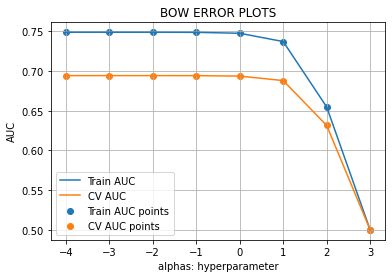

the best alpha value is 0.01


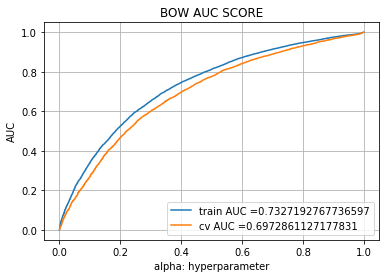

Train BOW confusion matrix


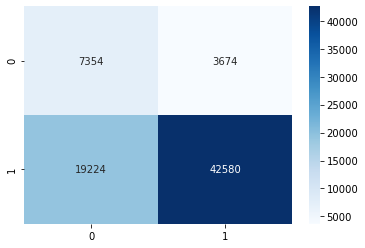

Test BOW confusion matrix


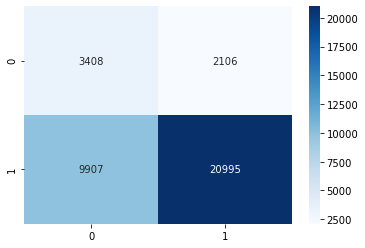

====================NEGATIVE===========================================

['students', 'school', 'learning', 'my', 'classroom', 'not', 'learn', 'they', 'help', 'the', 'my students', 'nannan', 'many', 'we', 'need', 'work', 'come', 'love', 'able', 'reading']
====================POSITIVE===========================================

['students', 'school', 'my', 'learning', 'classroom', 'the', 'they', 'not', 'my students', 'learn', 'help', 'many', 'nannan', 'we', 'need', 'work', 'reading', 'use', 'love', 'day']


In [55]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np
from sklearn.model_selection import GridSearchCV


clf=MultinomialNB(fit_prior=True, class_prior=[0.5, 0.5]) #with class_prior set as [0.5, 0.5] we see a little increase in accuracy.
params = {'alpha':[10**i for i in range(-4,4)]}
RSearch = GridSearchCV(clf,params, cv=3, scoring='roc_auc', return_train_score=True ,n_jobs=-1)
RSearch.fit(X_tr_bow,y_train)

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html (cv_results_)

result = pd.DataFrame.from_dict(RSearch.cv_results_)
result = result.sort_values(['param_alpha'])
train_auc = result['mean_train_score']
train_auc_std = result['std_train_score']
cv_auc = result['mean_test_score']
cv_auc_std = result['std_test_score']
alpha = result['param_alpha']

plt.plot([np.log10(alpha[i]) for i in range(len(alpha))], train_auc, label='Train AUC')
plt.plot([np.log10(alpha[i]) for i in range(len(alpha))], cv_auc, label='CV AUC')

plt.scatter([np.log10(alpha[i]) for i in range(len(alpha))], train_auc, label='Train AUC points')
plt.scatter([np.log10(alpha[i]) for i in range(len(alpha))], cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("alphas: hyperparameter")
plt.ylabel("AUC")
plt.title("BOW ERROR PLOTS")
plt.grid()
plt.show()

best_alpha=RSearch.best_estimator_
print("the best alpha value is",best_alpha.alpha)

auc_bow = auc_calc_function(best_alpha.alpha, X_tr_bow, y_train, X_cv_bow, y_cv, 'BOW')


# TF-IDF:

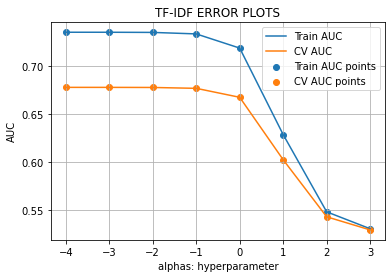

the best alpha value is 0.0001


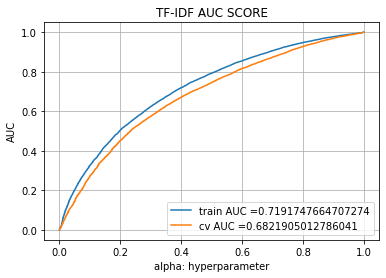

Train TF-IDF confusion matrix


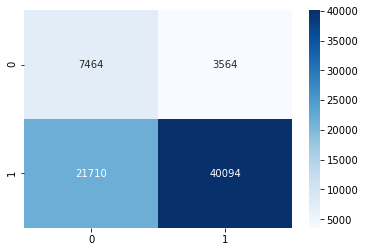

Test TF-IDF confusion matrix


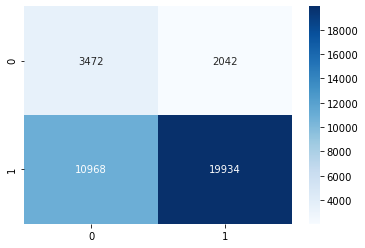

====================NEGATIVE===========================================

['students', 'school', 'learning', 'my', 'classroom', 'they', 'not', 'learn', 'help', 'the', 'my students', 'we', 'materials', 'many', 'need', 'work', 'reading', 'skills', 'want', 'come']
====================POSITIVE===========================================

['students', 'school', 'learning', 'classroom', 'my', 'they', 'the', 'reading', 'not', 'my students', 'help', 'learn', 'we', 'books', 'many', 'technology', 'work', 'need', 'use', 'love']


In [56]:
clf1=MultinomialNB(fit_prior=True, class_prior=[0.5, 0.5]) #with class_prior set as [0.5, 0.5] we see a little increase in accuracy.
params1 = {'alpha':[10**i for i in range(-4,4)]}
RSearch1 = GridSearchCV(clf1,params1, cv=3, scoring='roc_auc', return_train_score=True ,n_jobs=-1)
RSearch1.fit(X_tr_tf,y_train)

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html (cv_results_)

result = pd.DataFrame.from_dict(RSearch1.cv_results_)
result = result.sort_values(['param_alpha'])
train_auc = result['mean_train_score']
train_auc_std = result['std_train_score']
cv_auc = result['mean_test_score']
cv_auc_std = result['std_test_score']
alpha = result['param_alpha']

plt.plot([np.log10(alpha[i]) for i in range(len(alpha))], train_auc, label='Train AUC')
plt.plot([np.log10(alpha[i]) for i in range(len(alpha))], cv_auc, label='CV AUC')

plt.scatter([np.log10(alpha[i]) for i in range(len(alpha))], train_auc, label='Train AUC points')
plt.scatter([np.log10(alpha[i]) for i in range(len(alpha))], cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("alphas: hyperparameter")
plt.ylabel("AUC")
plt.title("TF-IDF ERROR PLOTS")
plt.grid()
plt.show()

best_alpha1=RSearch1.best_estimator_
print("the best alpha value is",best_alpha1.alpha)

auc_tf = auc_calc_function(best_alpha1.alpha, X_tr_tf, y_train, X_cv_tf, y_cv, 'TF-IDF')


<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [60]:
from prettytable import PrettyTable
pt=PrettyTable() 
pt.field_names = ["Vectorizer", "Model", "Hyper-Parameter", "AUC"] 
pt.add_row([" BOW ", "Naive Bayes", best_alpha.alpha,auc_bow])
pt.add_row([" TFIDF ", "Naive Bayes", best_alpha1.alpha, auc_tf]) 
print(pt)

+------------+-------------+-----------------+--------------------+
| Vectorizer |    Model    | Hyper-Parameter |        AUC         |
+------------+-------------+-----------------+--------------------+
|    BOW     | Naive Bayes |       0.01      | 0.6972861127177831 |
|   TFIDF    | Naive Bayes |      0.0001     | 0.6821905012786041 |
+------------+-------------+-----------------+--------------------+
